Project 2

Start date: March 4 2025

Machine learning experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids, NearMiss, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, f1_score, average_precision_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid

In [4]:
seed = random.randint(1000, 9999)
seed = 3543 #2851 # 
np.random.seed(seed)
random.seed(seed)
print(seed)

3543


In [5]:
## Load data
df = pd.read_csv('data/term-deposit-marketing-2020.csv')

In [6]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no


### Model 1

In [7]:
# Select demographic and financial fields
df_model1 = df.copy()
df_model1 = df.drop(columns=["contact", "day", "month", "duration", "campaign"])

# Apply Label Encoding to binary categorical features
binary_features = ["default", "housing", "loan", "y"]
label_encoders = {}
for col in binary_features:
    label_encoders[col] = LabelEncoder()
    df_model1[col] = label_encoders[col].fit_transform(df_model1[col])

# Apply One-Hot Encoding to multi-class categorical features
multi_class_features = ["job", "marital", "education"]
df_model1 = pd.get_dummies(df_model1, columns=multi_class_features, drop_first=True)

# Display the transformed dataset
df_model1.head()

,age,default,balance,housing,loan,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,58,0,2143,1,0,0,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
1,44,0,29,1,0,0,False,False,False,False,...,False,False,True,False,False,False,True,True,False,False
2,33,0,2,1,1,0,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
3,47,0,1506,1,0,0,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,33,0,1,0,0,0,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True


x_train shape:  (32000, 21)
y_train shape:  (32000,)
x_test shape:  (8000, 21)
y_test shape:  (8000,)


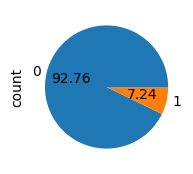

In [8]:
# Separate features and target variable
X = df_model1.drop(columns=["y"])
y = df_model1["y"]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Numerical features for scaling
numerical_features = ["age", "balance"]

# Apply Standard Scaling to numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Display the prepared training set
#X_train.head(3), y_train.head(3)

print('x_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

plt.figure(figsize=(2, 2))
y_train.value_counts().plot.pie(autopct='%.2f')
plt.show()

In [7]:
# ## Running LazyPredict multiple times to assess stability of the models
# # Number of iterations
# num_iterations = 50

# # Dictionary to store top 10 models per iteration
# top_models_per_iteration = []

# # Dictionary to store best accuracy and corresponding seed for each model
# best_seeds = defaultdict(lambda: (0, None))

# for _ in range(num_iterations):
#     # Split data with different random seed
#     seed = random.randint(1000, 9999)
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
#     # Initialize LazyClassifier
#     clf = LazyClassifier(verbose=0, predictions=False,ignore_warnings=True, custom_metric=recall_score,)
    
#     # Fit and evaluate models
#     models, _ = clf.fit(x_train, x_test, y_train, y_test)
    
#     # Get top 10 models for this iteration
#     top_10_models = models.head(5).index.tolist()
#     top_models_per_iteration.extend(top_10_models)
    
#     # Record best accuracy and corresponding seed
#     for model_name, row in models.iterrows():
#         accuracy = row['recall_score']
#         if accuracy > best_seeds[model_name][0]:
#             best_seeds[model_name] = (accuracy, seed)

# # Count occurrences of each model in the top 10
# model_counts = Counter(top_models_per_iteration)

# # Get the three most frequently appearing models
# best_models = model_counts.most_common(3)

# # Display results
# print("Top 3 Most Frequently Appearing Models in Top 5:")
# for model, count in best_models:
#     best_accuracy, best_seed = best_seeds[model]
#     print(f"{model}: {count} times, Best Accuracy: {best_accuracy:.4f}, Best Seed: {best_seed}")


In [25]:
clf = LazyClassifier(verbose=-1,ignore_warnings=True, predictions=True, random_state=seed, custom_metric=recall_score)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>), ('LabelPropagation', <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>), ('LabelSpreading', <class 'sklearn.semi_supervised._label_propagation.LabelSp

100%|██████████| 29/29 [00:33<00:00,  1.14s/it]

[LightGBM] [Info] Number of positive: 2317, number of negative: 29683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072406 -> initscore=-2.550301
[LightGBM] [Info] Start training from score -2.550301


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken
Model,,,,,,
NearestCentroid,0.62,0.57,0.57,0.71,0.52,0.02
RandomForestClassifier,0.90,0.53,0.53,0.89,0.10,4.26
DecisionTreeClassifier,0.88,0.53,0.53,0.88,0.13,0.14
ExtraTreesClassifier,0.88,0.53,0.53,0.88,0.12,2.49
ExtraTreeClassifier,0.88,0.53,0.53,0.88,0.11,0.05
BaggingClassifier,0.91,0.52,0.52,0.89,0.08,0.78
PassiveAggressiveClassifier,0.85,0.52,0.52,0.86,0.13,0.06
XGBClassifier,0.93,0.51,0.51,0.90,0.02,0.20
KNeighborsClassifier,0.92,0.51,0.51,0.89,0.02,0.71


How to select the best model?

We can't use accuracy because the dataset is imbalanced.
Balanced accuracy = average recall (true positive rate) calculated separately for each class. This is more suitable when the data is imbalanced. 
We can used a combination of balanced accuracy, ROC AUC, and F1 score to select top models. F1 score is useful when you care about true positives more than true negatives.

For cases where metrics are equal, we can use model complexity, interpretability and data types to choose the models.
Ex: Tree-based models work well on tasks involving imbalanced dataset.

Initial set of models selected:
1. Nearest centroid - Highest balanced acc and AUC ROC. The simplest model.
2. Random forest - Ensemble bagging model. Could be good for imbalanced data.
3. Decision tree - Simpler and more interpretable than random forest. Can be used with categorical data without encoding. May not perform well with imbalanced data.
4. XGBoost - Complex, but more powerful model that could give best performance after finetuning. Can adjust hyperparameters to handle imbalanced data.

Now, evaluate these models further using cross-validation.

In [9]:
def display_results(model, model_name, X_train, y_train, X_test, y_test):
    
   # model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    metrics = []
    metrics.append([accuracy, recall, precision])

    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(model_name)

    metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
    print(metrics_df)
    plt.show()

In [10]:
def evaluate_models(classifiers, X_train, y_train, X_test, y_test, preprocessing = [], seed=42, folds=5):
    metrics = []
    cm_all = []
    cross_val_f1 = []
    cross_val_bAcc = []
    cross_val_aucpr = []
    

    #fig, ax = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)

    for idx, (clf_name, clf) in enumerate(classifiers.items()):

        steps =  preprocessing.copy() # otherwise steps gets updated inplace

        model = clf

        # Initialize StratifiedKFold
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

        steps.append(('m', model))

        pipeline = Pipeline(steps=steps)

        # Perform stratified cross-validation and get the scores
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
        cross_val_f1.append([clf_name] + list(scores) + [scores.mean()])
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='balanced_accuracy')
        cross_val_bAcc.append([clf_name] + list(scores) + [scores.mean()])
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='average_precision')
        cross_val_aucpr.append([clf_name] + list(scores) + [scores.mean()])

        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred, normalize=True)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1_scr = f1_score(y_test, y_pred)
        pr_auc = average_precision_score(y_test, y_pred)

        metrics.append([clf_name, accuracy, balanced_acc, recall, precision, f1_scr, pr_auc])
        cm = confusion_matrix(y_test, y_pred)
        cm_all.append(cm)
        # s = sns.heatmap(cm, ax=ax[idx], cbar=False, annot=True, fmt='g', cmap='Blues')
        # s.set_xlabel('Pred')
        # s.set_ylabel('True')
        # s.set_title(clf_name)

    columns = ['Model'] + ['Fold' + str(f) for f in range(folds)] + ['Average']
    cross_val_f1_df = pd.DataFrame(cross_val_f1, columns=columns)
    cross_val_bAcc_df = pd.DataFrame(cross_val_bAcc, columns=columns)
    cross_val_aucpr_df = pd.DataFrame(cross_val_aucpr, columns=columns)
    metrics_df = pd.DataFrame(metrics, columns=['Model', 'Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC PR'])

    return cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm_all

def plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm):
        
    print('Performance on the test: ')
    # Adjust display options
    pd.set_option('display.width', 1000)  # Increase width
    pd.set_option('display.max_columns', None)  # Show all columns
    print(metrics_df)
    
    fig, ax = plt.subplots(1, len(classifiers), figsize=(3*len(classifiers), 3), constrained_layout=True)
    for idx, (clf_name, clf) in enumerate(classifiers.items()):
        s = sns.heatmap(cm[idx], ax=ax[idx], cbar=False, annot=True, fmt='g', cmap='Blues')
        s.set_xlabel('Pred')
        s.set_ylabel('True')
        s.set_title(clf_name)
    fig.suptitle('Test set confusion matrices', fontsize=10)
    plt.show()

    # Plotting the dataframes as barplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    # Plot for cross_val_f1_df
    cross_val_f1_df.plot(kind='bar', ax=axes[0], title='F1 Score')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('F1 Score')
    axes[0].set_xticklabels(cross_val_f1_df['Model'], rotation=45, ha='right')

    # Plot for cross_val_bAcc_df
    cross_val_bAcc_df.plot(kind='bar', ax=axes[1], title='Balanced Accuracy')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Balanced Accuracy')
    axes[1].set_xticklabels(cross_val_bAcc_df['Model'], rotation=45, ha='right')

    # Plot for cross_val_aucpr_df
    cross_val_aucpr_df.plot(kind='bar', ax=axes[2], title='AUC PR')
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('AUC PR')
    axes[2].set_xticklabels(cross_val_aucpr_df['Model'], rotation=45, ha='right')
    fig.suptitle('Cross validation metrics on the training set', fontsize=10)
    plt.show()


Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.56    0.51       0.09      0.16    0.08
1     DecisionTree      0.86               0.52    0.13       0.11      0.12    0.08
2     RandomForest      0.92               0.53    0.08       0.24      0.12    0.09
3          XGBoost      0.93               0.51    0.02       0.34      0.04    0.08


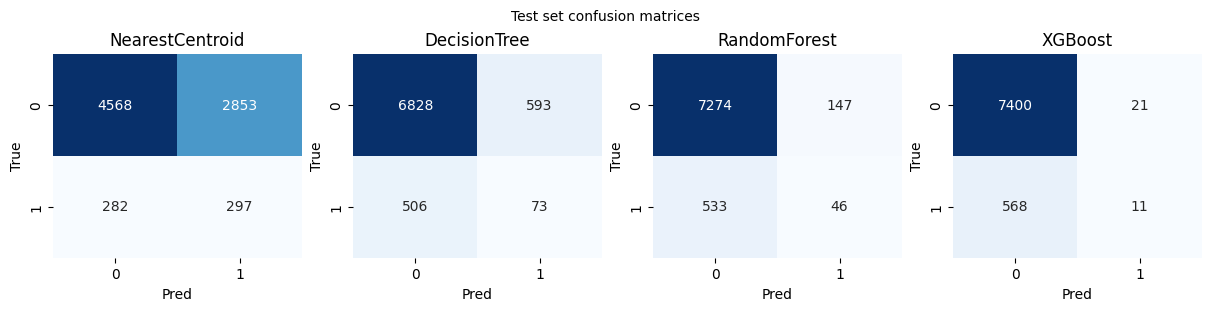

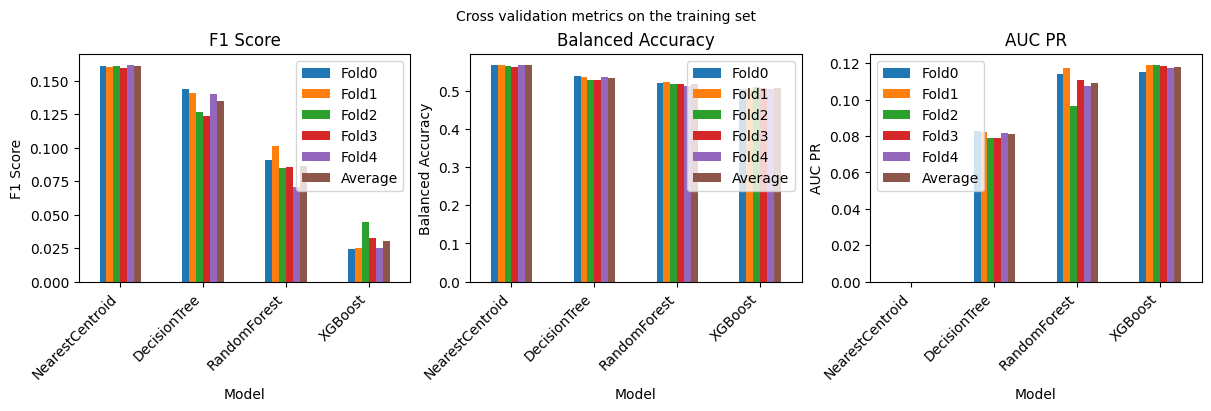

In [26]:
# Re-training the selected models to evaluate consistency with LazyPredict results

classifiers = {
    'NearestCentroid': NearestCentroid(),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)


Balanced accuracies (of cross validation) are not highly different among models. But, F1 scores are more significantly different.

PR-AUC is a good metric for assessing imbalanced data tasks, especially when we are interested in the positive (often minority) class. PR-AUC shows the opposite variation. NearestCentroid has NaNs probably because it is simple and sensitive to data distributions, thus not classifiying any positives correctly. 
So, we can assume the other three works better with this dataset. We can eliminate nearestCentroid.

### Handling data imbalance
- Data-level (resampling)
- Model-level 
    - using models that are suitable for imbalanced data (ex: tree-based algorithms) 
    - making the model more robust to class imbalance (adjusting the loss function)
    - combining techniques (undersampling + ensemble: training multiple models for sections of the majority class)
- Metric-level (using suitable evaluation metrics)
    - precision, recall, F1 and AUC precision-recall measure performance with respect to the positive class.
- Tuning decision threshold using predict_proba instead of using predict function.

### Resampling

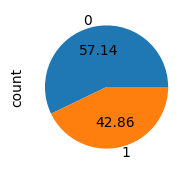

In [27]:
# Over-sampling
smote = SMOTE(random_state=seed, sampling_strategy=0.75) #sampling_strategy = #minority_samples_after_resampling/#majority_samples
X_train_overSam, y_train_overSam = smote.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_overSam.value_counts().plot.pie(autopct='%.2f')
plt.show()

In [28]:
# Under-sampling

# 1. RandomUnderSampler
rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.5)
X_underSam_rus, y_underSam_rus = rus.fit_resample(X_train, y_train)
print("Class distribution after RandomUnderSampler:", pd.Series(y_underSam_rus).value_counts())

# 2. TomekLinks
tl = TomekLinks()
X_underSam_tl, y_underSam_tl = tl.fit_resample(X_train, y_train)
print("Class distribution after TomekLinks:", pd.Series(y_underSam_tl).value_counts())

# 3. ClusterCentroids
cc = ClusterCentroids(random_state=seed, sampling_strategy=0.5)
X_underSam_cc, y_underSam_cc = cc.fit_resample(X_train, y_train)
print("Class distribution after ClusterCentroids:", pd.Series(y_underSam_cc).value_counts())


Class distribution after RandomUnderSampler: y
0    4634
1    2317
Name: count, dtype: int64
Class distribution after TomekLinks: y
0    28632
1     2317
Name: count, dtype: int64
Class distribution after ClusterCentroids: y
0    4634
1    2317
Name: count, dtype: int64


Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.57    0.53       0.10      0.16    0.09
1     DecisionTree      0.84               0.52    0.15       0.10      0.12    0.08
2     RandomForest      0.86               0.53    0.16       0.12      0.14    0.08
3          XGBoost      0.91               0.53    0.09       0.22      0.12    0.08


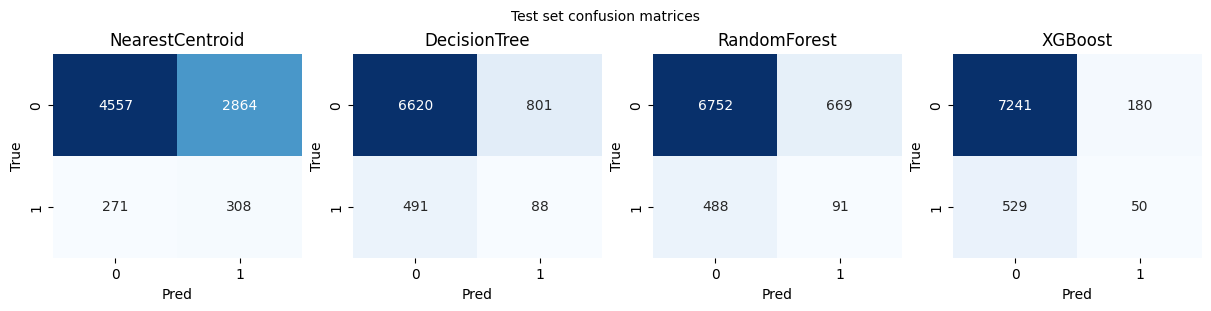

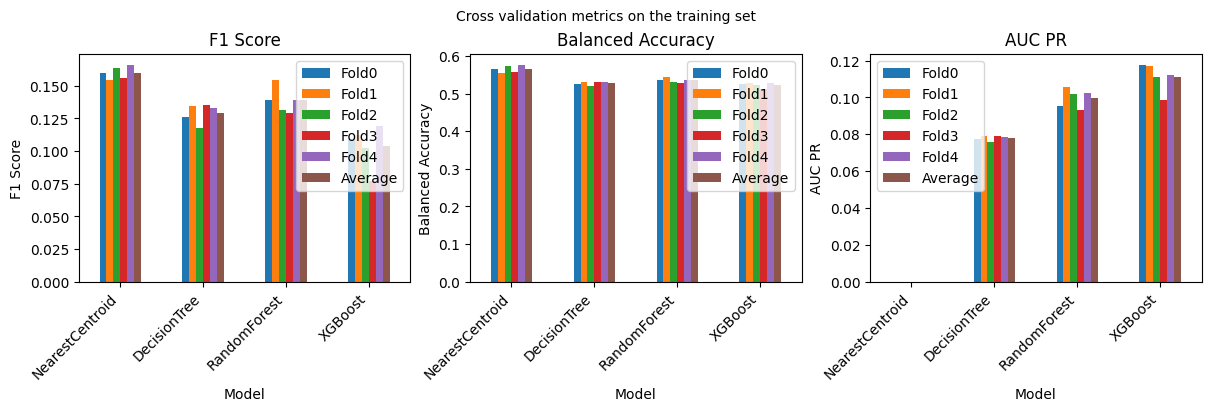

In [12]:
# Evalutating SMOTE

classifiers = {
    'NearestCentroid': NearestCentroid(),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}

smote = SMOTE(random_state=seed, sampling_strategy=0.5)
preprocessing = [('r', smote)]

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Sampling ratio: 0.1
Sampling ratio: 0.25
Sampling ratio: 0.5
Sampling ratio: 0.75
Sampling ratio: 1.0


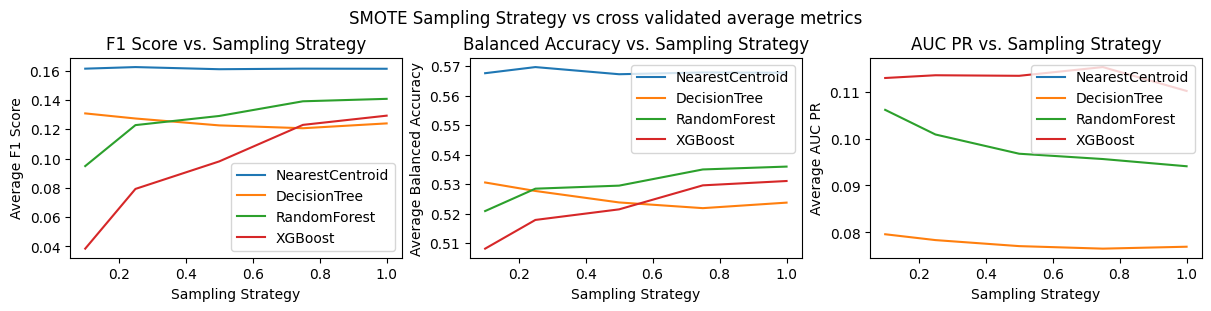

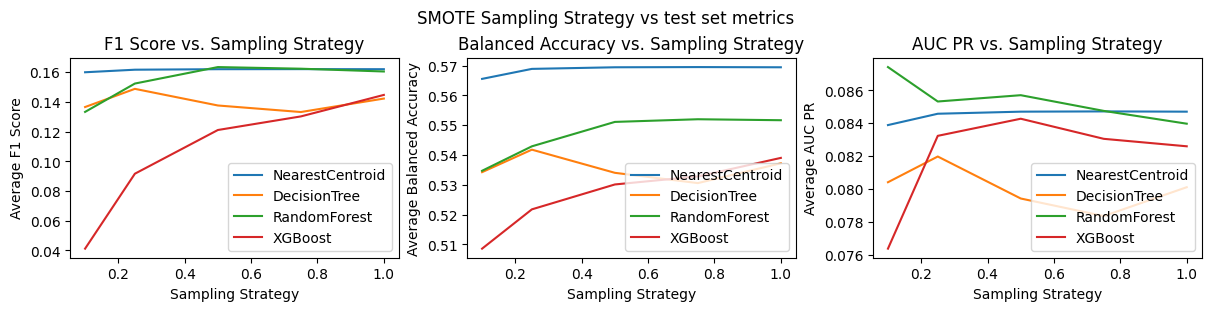

In [29]:
# Evaluating SMOTE for different sampling ratios

sampling_strategies = [0.1, 0.25, 0.5, 0.75, 1.0]
seed = seed

avg_f1_results = {}
avg_bacc_results = {}
avg_aucpr_results = {}

test_f1 = {}
test_bacc = {}
test_aucpr = {}

for sampling_strategy in sampling_strategies:
    print(f'Sampling ratio: {sampling_strategy}')
    smote = SMOTE(random_state=seed, sampling_strategy=sampling_strategy)
    
    #X_train_overSam, y_train_overSam = smote.fit_resample(X_train, y_train)

    preprocessing = [('r', smote)]

    #cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(classifiers, X_train_overSam, y_train_overSam, X_test, y_test, seed=seed)
    cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

    # Store average metrics
    avg_f1_results[sampling_strategy] = cross_val_f1_df[['Model', 'Average']].set_index('Model')['Average'].to_dict()
    avg_bacc_results[sampling_strategy] = cross_val_bAcc_df[['Model', 'Average']].set_index('Model')['Average'].to_dict()
    avg_aucpr_results[sampling_strategy] = cross_val_aucpr_df[['Model', 'Average']].set_index('Model')['Average'].to_dict()

    # Store test metrics
    test_f1[sampling_strategy] = metrics_df[['Model', 'F1 Score']].set_index('Model')['F1 Score'].to_dict()
    test_bacc[sampling_strategy] = metrics_df[['Model', 'Balanced Accuracy']].set_index('Model')['Balanced Accuracy'].to_dict()
    test_aucpr[sampling_strategy] = metrics_df[['Model', 'AUC PR']].set_index('Model')['AUC PR'].to_dict()

    #plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

# Convert results to DataFrames for plotting
f1_df_plot = pd.DataFrame(avg_f1_results).T
bacc_df_plot = pd.DataFrame(avg_bacc_results).T
aucpr_df_plot = pd.DataFrame(avg_aucpr_results).T
f1_df_plot.index.name = 'Sampling Strategy'
bacc_df_plot.index.name = 'Sampling Strategy'
aucpr_df_plot.index.name = 'Sampling Strategy'

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

f1_df_plot.plot(ax=axes[0], kind='line', title='F1 Score vs. Sampling Strategy')
axes[0].set_ylabel('Average F1 Score')
axes[0].set_xlabel('Sampling Strategy')

bacc_df_plot.plot(ax=axes[1], kind='line', title='Balanced Accuracy vs. Sampling Strategy')
axes[1].set_ylabel('Average Balanced Accuracy')
axes[1].set_xlabel('Sampling Strategy')

aucpr_df_plot.plot(ax=axes[2], kind='line', title='AUC PR vs. Sampling Strategy')
axes[2].set_ylabel('Average AUC PR')
axes[2].set_xlabel('Sampling Strategy')

fig.suptitle('SMOTE Sampling Strategy vs cross validated average metrics', fontsize=12)
plt.show()

# Convert results to DataFrames for plotting
test_f1_df_plot = pd.DataFrame(test_f1).T
test_bacc_df_plot = pd.DataFrame(test_bacc).T
test_aucpr_df_plot = pd.DataFrame(test_aucpr).T
test_f1_df_plot.index.name = 'Sampling Strategy'
test_bacc_df_plot.index.name = 'Sampling Strategy'
test_aucpr_df_plot.index.name = 'Sampling Strategy'

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

test_f1_df_plot.plot(ax=axes[0], kind='line', title='F1 Score vs. Sampling Strategy')
axes[0].set_ylabel('Average F1 Score')
axes[0].set_xlabel('Sampling Strategy')

test_bacc_df_plot.plot(ax=axes[1], kind='line', title='Balanced Accuracy vs. Sampling Strategy')
axes[1].set_ylabel('Average Balanced Accuracy')
axes[1].set_xlabel('Sampling Strategy')

test_aucpr_df_plot.plot(ax=axes[2], kind='line', title='AUC PR vs. Sampling Strategy')
axes[2].set_ylabel('Average AUC PR')
axes[2].set_xlabel('Sampling Strategy')

fig.suptitle('SMOTE Sampling Strategy vs test set metrics', fontsize=12)
plt.show()

Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.57    0.53       0.10      0.17    0.09
1     DecisionTree      0.67               0.54    0.39       0.09      0.15    0.08
2     RandomForest      0.77               0.56    0.31       0.11      0.17    0.09
3          XGBoost      0.83               0.56    0.26       0.13      0.18    0.09


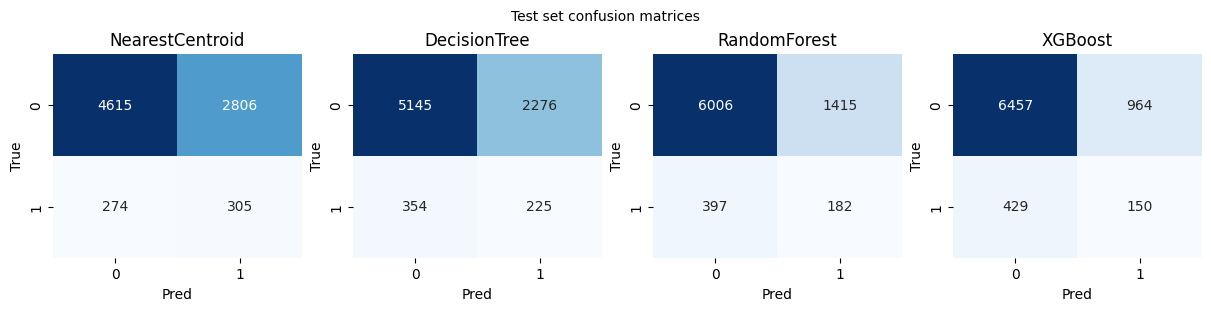

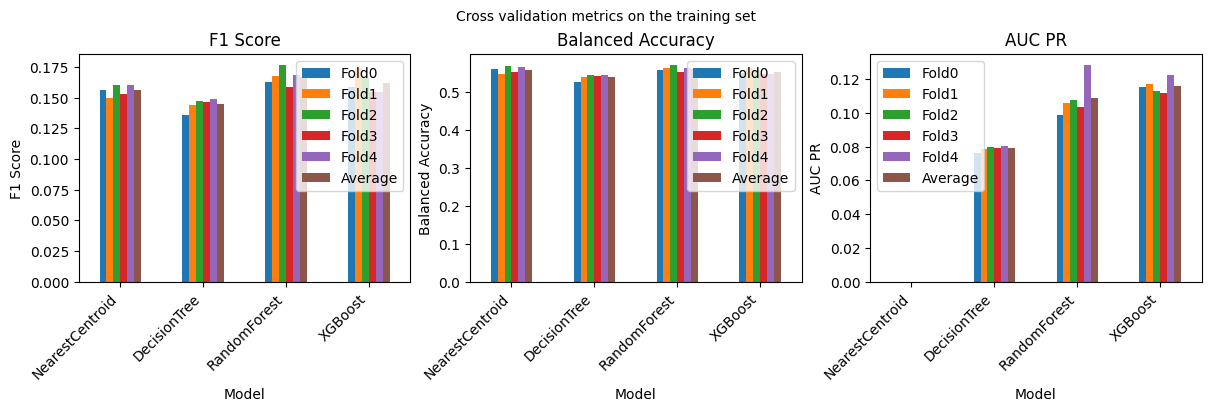

In [11]:
# Evalutating under sampling

classifiers = {
    'NearestCentroid': NearestCentroid(),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed)
}

rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.5)
preprocessing = [('u', rus)]

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Under-sampling increases the true positives, but also increases false positives. This could be because there are not enough negative data samples to learn the distribution well.

But, what we are trying to do is create a balance between true positives and false positives.

In [ ]:
# Combining under-sampling and over-sampling
# Oversample the minority class and then undersample the majority class

smote = SMOTE(random_state=seed, sampling_strategy=0.5) #sampling_strategy = #minority_samples_after_resampling/#majority_samples
X_train_overSam, y_train_overSam = smote.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_overSam.value_counts().plot.pie(autopct='%.2f')
plt.show()
print("Class distribution after over sampling:", pd.Series(y_train_overSam).value_counts())

# 1. RandomUnderSampler
rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.5)
X_underSam_rus, y_underSam_rus = rus.fit_resample(X_train_overSam, y_train_overSam)
print("Class distribution after RandomUnderSampler:", pd.Series(y_underSam_rus).value_counts())

# 2. TomekLinks
tl = TomekLinks(sampling_strategy='majority')
X_underSam_tl, y_underSam_tl = tl.fit_resample(X_train_overSam, y_train_overSam)
print("Class distribution after TomekLinks:", pd.Series(y_underSam_tl).value_counts())

# 3. ClusterCentroids
cc = ClusterCentroids(random_state=seed, sampling_strategy=0.5)
X_underSam_cc, y_underSam_cc = cc.fit_resample(X_train_overSam, y_train_overSam)
print("Class distribution after ClusterCentroids:", pd.Series(y_underSam_cc).value_counts())


Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.61               0.57    0.53       0.10      0.16    0.08
1     DecisionTree      0.82               0.53    0.18       0.10      0.13    0.08
2     RandomForest      0.81               0.55    0.24       0.12      0.16    0.08
3          XGBoost      0.88               0.54    0.15       0.15      0.15    0.08


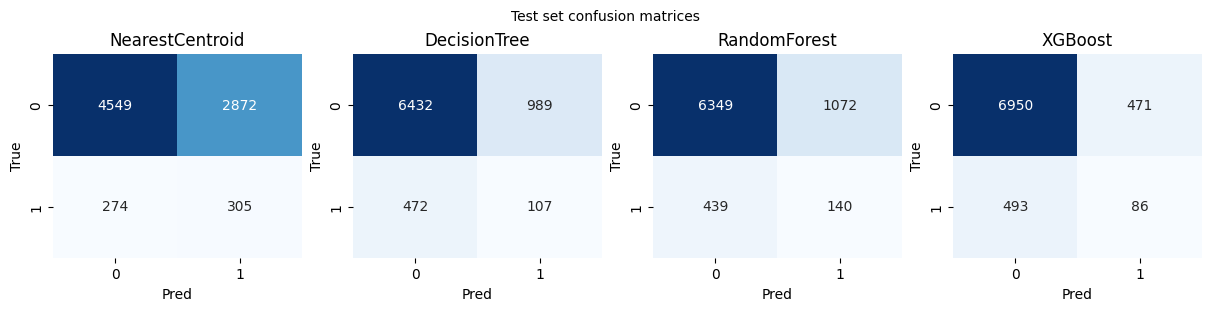

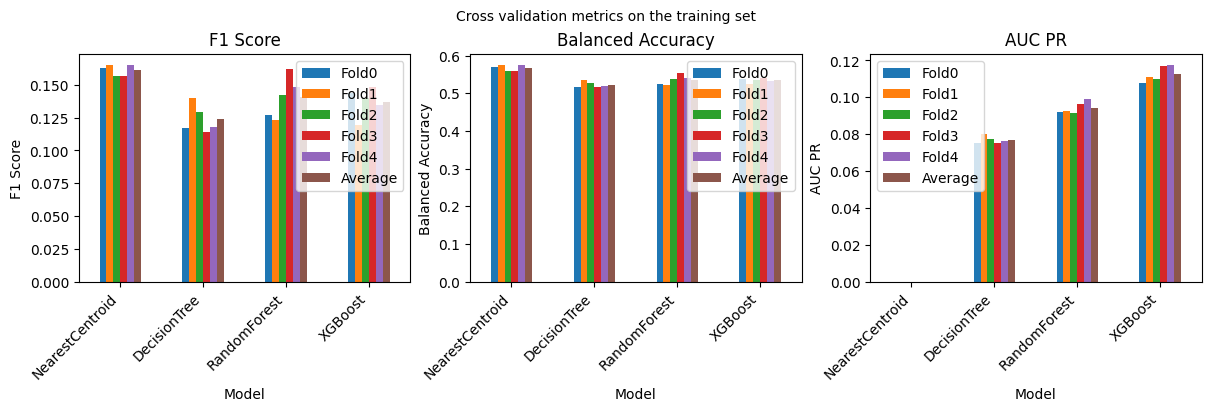

In [31]:
smote = SMOTE(random_state=seed, sampling_strategy=0.1) 
tomek = TomekLinks(sampling_strategy='majority')
resample = SMOTETomek(random_state=seed)#SMOTETomek(smote=smote, tomek=tomek)
preprocessing = [('r', resample)]
cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

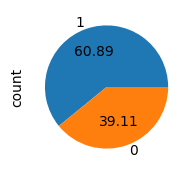

Class distribution after over sampling: y
1    29683
0    19064
Name: count, dtype: int64


In [21]:
smote = SMOTE(random_state=seed) 
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_train_overSam, y_train_overSam = resample.fit_resample(X_train, y_train)
plt.figure(figsize=(2, 2))
y_train_overSam.value_counts().plot.pie(autopct='%.2f')
plt.show()
print("Class distribution after over sampling:", pd.Series(y_train_overSam).value_counts())

Performance on the test: 
             Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0  NearestCentroid      0.59               0.57    0.55       0.10      0.16    0.09
1     DecisionTree      0.71               0.54    0.35       0.09      0.15    0.08
2     RandomForest      0.66               0.54    0.40       0.09      0.15    0.08
3          XGBoost      0.75               0.55    0.32       0.11      0.16    0.08


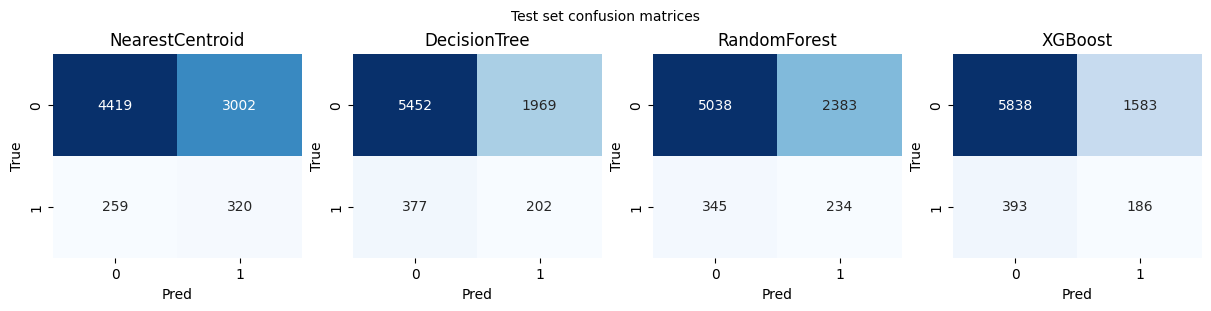

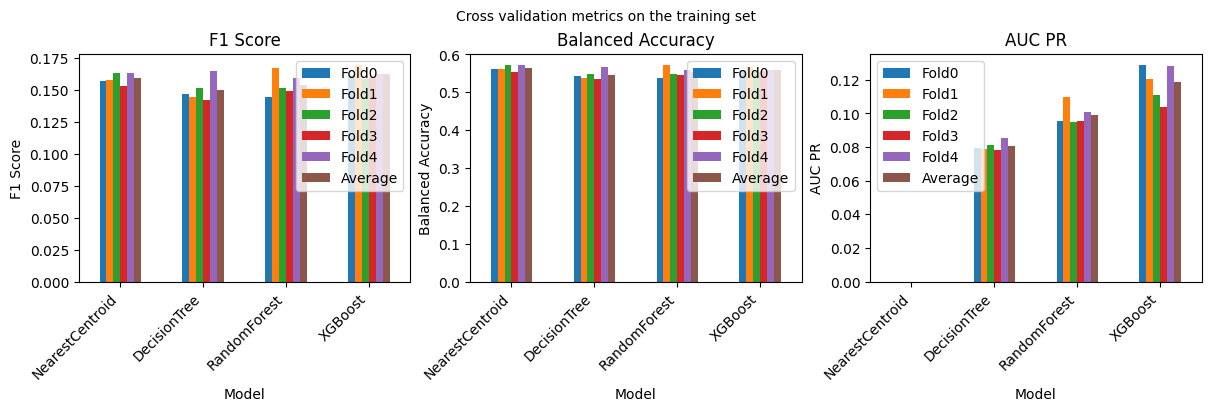

In [20]:
smote = SMOTE(random_state=seed)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

SMOTEENN seem to be the giving the best performance.
Decision tree vs XGBoost: Same true positive rate, while XGBoost shows lower false positive rate. 

One thing to notice: nearestCentroid does not show a large improvement with any of the resampling methods.

### Adjusting model parameters

In [26]:
## Resampling before tuning
smote = SMOTE(random_state=seed, sampling_strategy=0.5)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)
print("Class distribution after over sampling:", pd.Series(y_train_Sam).value_counts())

Class distribution after over sampling: y
0    20504
1    14841
Name: count, dtype: int64


Class distribution after over sampling: y
0    20504
1    14841
Name: count, dtype: int64
Performance on the test: 
           Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        xgboost      0.85               0.56    0.21       0.14      0.17    0.09
1  xgboost_tuned      0.81               0.56    0.26       0.12      0.16    0.08


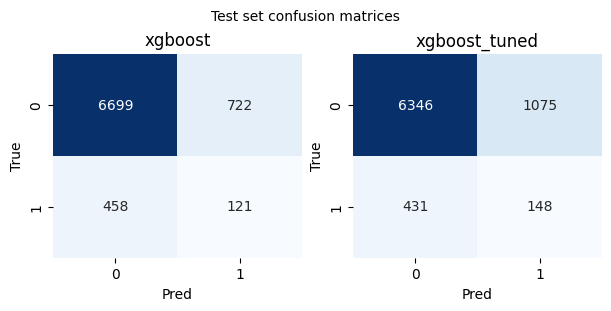

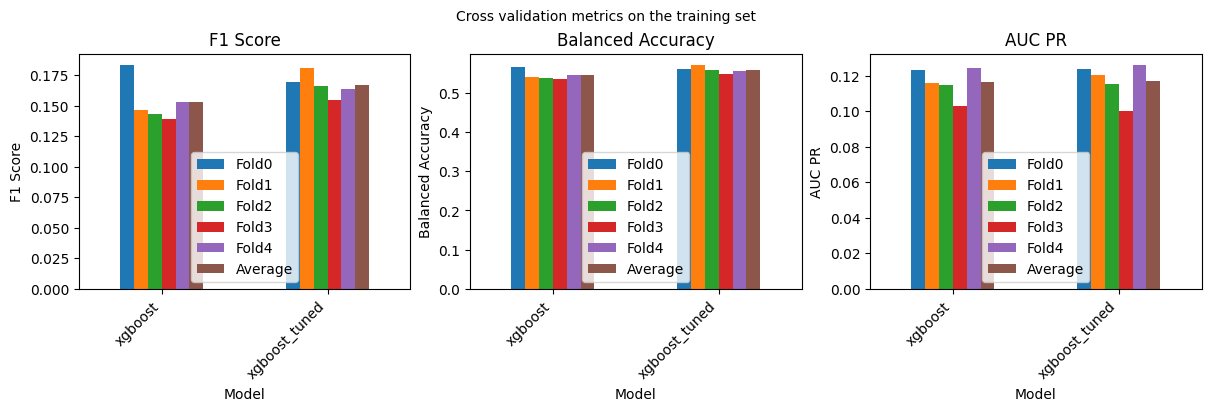

In [27]:
# pos_frac = y.mean()
# print('pos_frac', pos_frac)

## Resampling before tuning
smote = SMOTE(random_state=seed, sampling_strategy=0.5)
resample = SMOTEENN(smote=smote, enn=EditedNearestNeighbours(sampling_strategy='majority'))
preprocessing = [('r', resample)]
X_train_Sam, y_train_Sam = resample.fit_resample(X_train, y_train)
print("Class distribution after over sampling:", pd.Series(y_train_Sam).value_counts())

counts = y_train_Sam.value_counts()
frac = counts[0]/counts[1]
model_tuned= XGBClassifier(scale_pos_weight=frac, random_state=seed)
model = XGBClassifier(random_state=seed)
classifiers = {'xgboost': model,
              'xgboost_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, preprocessing=preprocessing, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)


Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        randomForest      0.92               0.53    0.08       0.24      0.12    0.09
1  randomForest_tuned      0.91               0.53    0.08       0.22      0.12    0.08


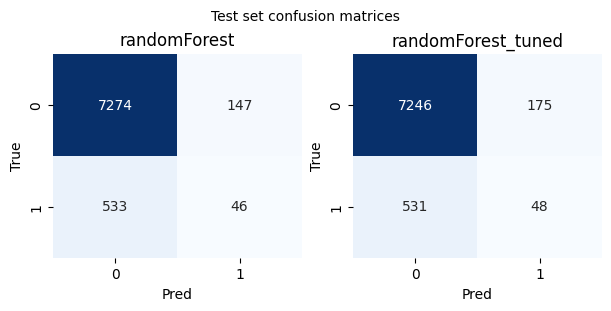

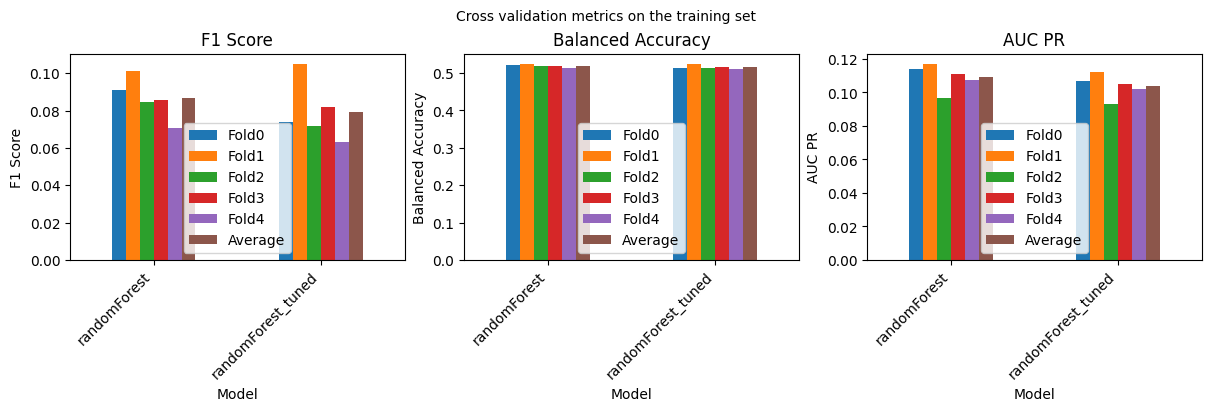

In [23]:
model_tuned= RandomForestClassifier(class_weight='balanced_subsample', random_state=seed)
model = RandomForestClassifier(random_state=seed)
classifiers = {'randomForest': model,
              'randomForest_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

Performance on the test: 
                Model  Accuracy  Balanced Accuracy  Recall  Precision  F1 Score  AUC PR
0        decisionTree      0.86               0.52    0.13       0.11      0.12    0.08
1  decisionTree_tuned      0.86               0.54    0.16       0.13      0.14    0.08


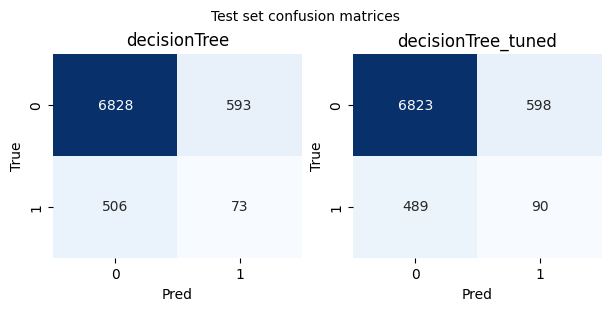

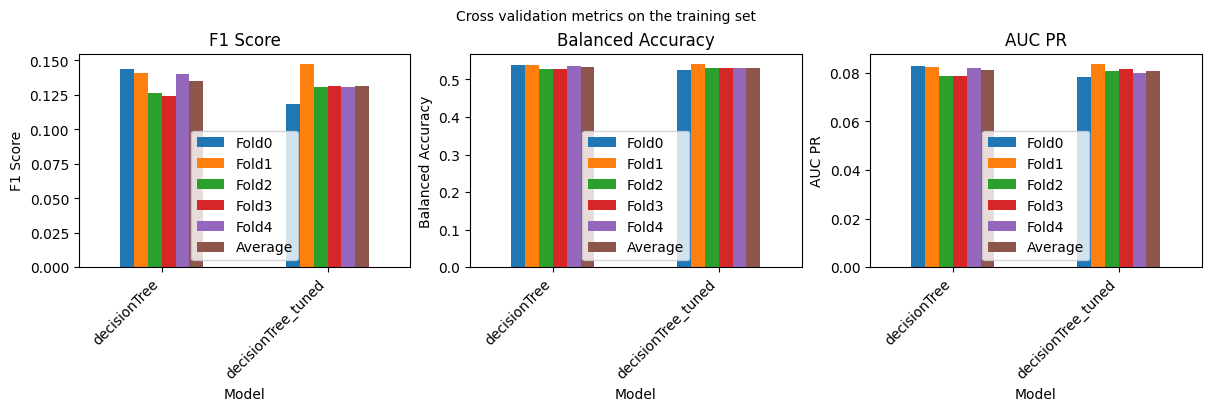

In [24]:
model_tuned= DecisionTreeClassifier(class_weight='balanced', random_state=seed)
model = DecisionTreeClassifier(random_state=seed)
classifiers = {'decisionTree': model,
              'decisionTree_tuned': model_tuned}

cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm = evaluate_models(
    classifiers, X_train, y_train, X_test, y_test, seed=seed)

plot_cross_val_metrics(classifiers, cross_val_f1_df, cross_val_bAcc_df, cross_val_aucpr_df, metrics_df, cm)

### Use class weights to manage imbalance
https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4

### Tuning prediction threshold